**PODPUNKTY DO ANALIZY ZBIORU**


1. *Wgranie danych*

    1.1. połączenie z dyskiem

    1.2. unzip
2. *Wgranie bibliotek*
3. *Analiza danych z csv*

    3.1. podgląd

    3.2. distribution of classes
    
    3.3. 

4. *Podgląd danych wizualnie*
5. *Podział na foldery klas*

    5.1. Dodanie ścieżki do każdego zdjęcia

    5.2. Utworzenie folderów 

6. *Podział na zbiory test, train, validation*

    6.1. Standaryzacja

    6.2. Zrównoważenie wag

    6.3. Splitting

7. *Agumentacja obrazów*
8. *Trenowanie modelu*
9. *Testowanie modelu*









#**DZIAŁAMY TYLKO NA META DATA I OBRAZKACH !!!**

POłĄCZENIE Z DYSKIEM

In [1]:
# Mount Google Drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


WGRANIE DATASET

In [ ]:
# Unzip data in Google Drive
#!unzip -u '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM_1.zip' -d '/content/drive/My Drive/INZYNIERKA/Dane_1'
#!unzip '/content/drive/My Drive/INZYNIERKA/Dane_2/HAM_2.zip' -d '/content/drive/My Drive/INZYNIERKA/Dane_2'

WGRANIE BIBLIOTEK

In [26]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import sklearn.utils
from tensorflow import keras

from keras import regularizers

from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import adam_v2, Adam

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D, Activation

from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.efficientnet import EfficientNetB1

PODGLĄD DANYCH

In [ ]:
# First 5 rows meta data
meta_data = pd.read_csv('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
meta_data.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [ ]:
def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

summary_table(meta_data)

,Name,dtypes,Missing,Uniques
0,lesion_id,object,0,7470
1,image_id,object,0,10015
2,dx,object,0,7
3,dx_type,object,0,4
4,age,float64,57,18
5,sex,object,0,3
6,localization,object,0,15


In [ ]:
pd.DataFrame(meta_data.dtypes,columns=['dtypes'])

,dtypes
lesion_id,object
image_id,object
dx,object
dx_type,object
age,float64
sex,object
localization,object


In [ ]:
#Checking for NA
print(meta_data.isna().sum())
null_data = meta_data[meta_data.isnull().any(axis=1)]
#print(null_data)

#Wypełnić czy usunąć NA?

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


WYKRESY

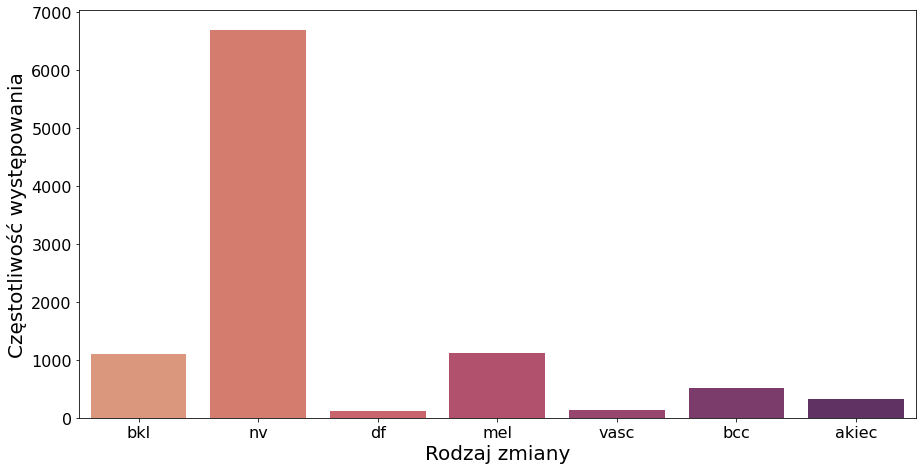

In [ ]:
plt.figure(figsize=(15, 7.5))

sns.countplot(x = 'dx', data = meta_data, palette='flare')

plt.xlabel('Rodzaj zmiany', size=20)
plt.ylabel('Częstotliwość występowania', size=20)
#plt.title('Rozkład danych', size=22)
plt.show()

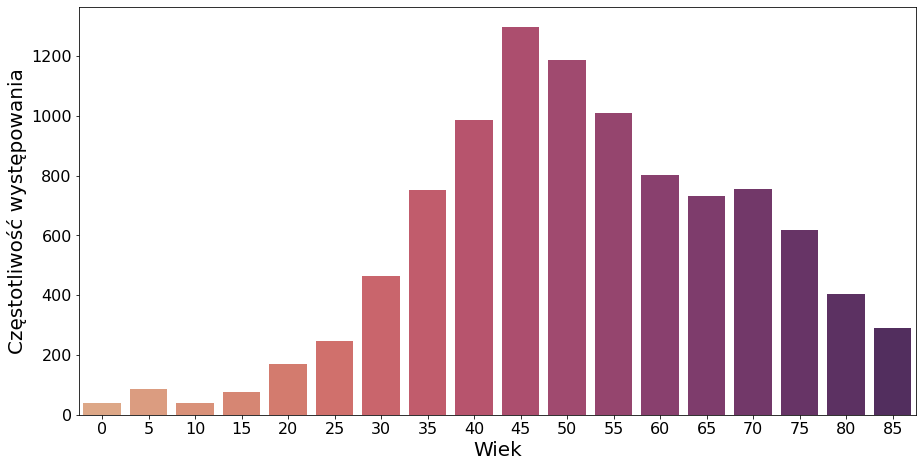

In [ ]:
plt.figure(figsize=(15, 7.5))

sns.countplot(x = 'age', data = meta_data, palette='flare')

plt.xlabel('Wiek', size=20)
plt.ylabel('Częstotliwość występowania', size=20)
#plt.title('Rozkład danych', size=22)
plt.xticks(ticks = np.arange(0, 18, 1), labels = np.arange(0, 90 ,5))
plt.show()

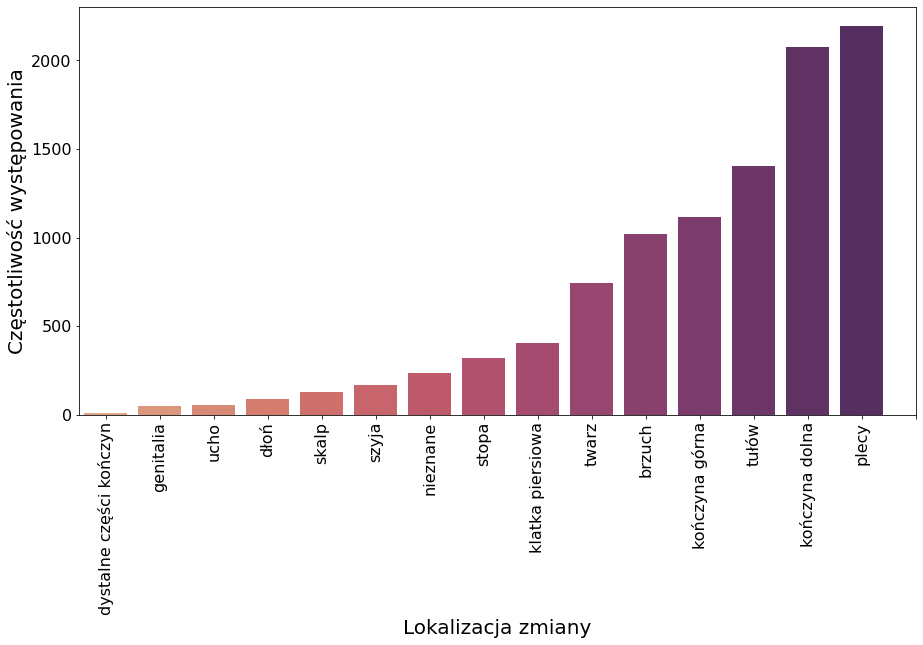

In [ ]:
labels_loc = ['dystalne części kończyn', 'genitalia', 'ucho', 'dłoń', 'skalp', 'szyja', 'nieznane', 'stopa', 'klatka piersiowa', 'twarz', 'brzuch', 'kończyna górna', 'tułów', 'kończyna dolna', 'plecy',]

plt.figure(figsize=(15, 7.5))

sns.countplot(x = 'localization', data = meta_data, palette = 'flare', order=np.flip(meta_data['localization'].value_counts().index))

plt.xlabel('Lokalizacja zmiany', size=20)
plt.ylabel('Częstotliwość występowania', size=20)
#plt.title('Rozkład danych', size=22)
plt.xticks(rotation=90, ticks = np.arange(0, 16, 1), labels = labels_loc)
plt.show()

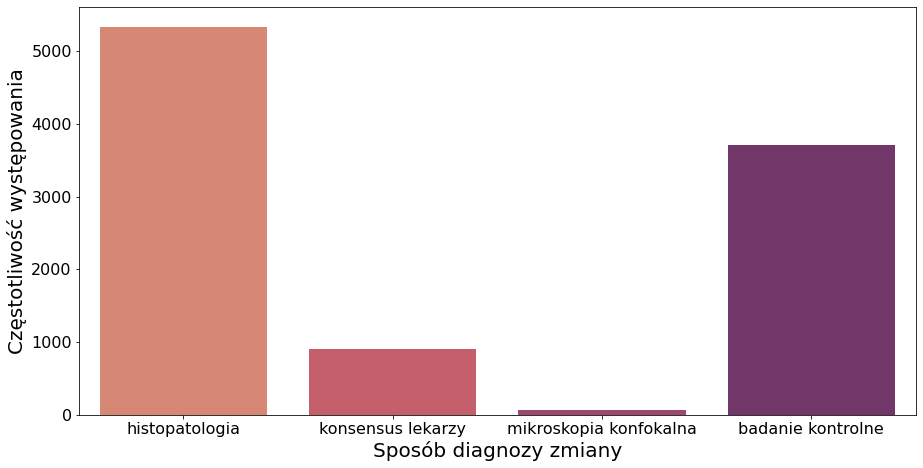

In [ ]:
plt.figure(figsize=(15, 7.5))

sns.countplot(x = 'dx_type', data = meta_data, palette = 'flare')

labels_histo = ['histopatologia', 'konsensus lekarzy', 'mikroskopia konfokalna', 'badanie kontrolne']

plt.xlabel('Sposób diagnozy zmiany', size=20)
plt.ylabel('Częstotliwość występowania', size=20)
plt.xticks(ticks = np.arange(0, 4, 1), labels = labels_histo)
#plt.title('Rozkład danych', size=22)
plt.show()

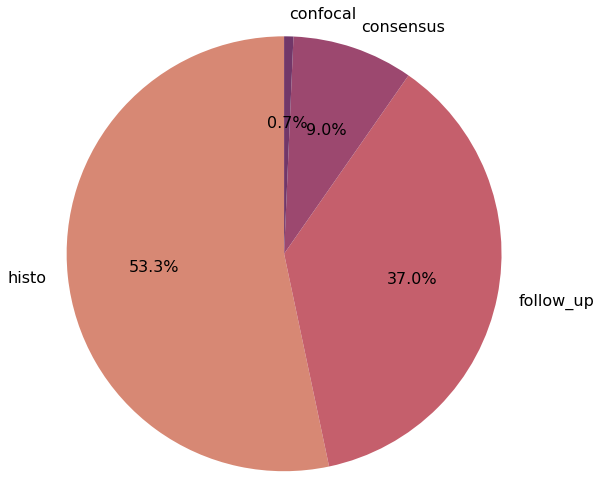

In [ ]:
colors = ["#D78874", "#C55F6C", "#9C486F", "#713769"]

plt.figure(figsize=(10, 5))
plt.rcParams['font.size'] = '16'

plt.pie(x = meta_data['dx_type'].value_counts(), 
        labels = meta_data['dx_type'].value_counts().index, 
        autopct="%.1f%%", 
        colors = colors,
        radius = 2,
        startangle = 90)
#plt.title('Frequency Distribution of Dx_Type Classes', size=16)
plt.show()

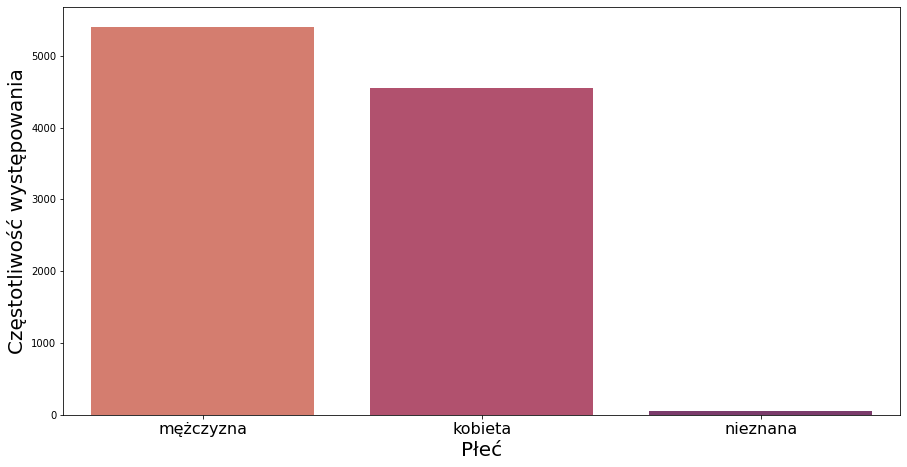

In [ ]:
plt.figure(figsize=(15, 7.5))

sns.countplot(x = 'sex', data = meta_data, palette = 'flare')
labels_sex = ['mężczyzna', 'kobieta', 'nieznana']

plt.xlabel('Płeć', size=20)
plt.ylabel('Częstotliwość występowania', size=20)
plt.xticks(ticks = np.arange(0, 3, 1), labels = labels_sex, size=16)
#plt.title('Rozkład danych', size=22)
plt.show()

In [ ]:
labels = meta_data['sex'].value_counts().index
labels

Index(['male', 'female', 'unknown'], dtype='object')

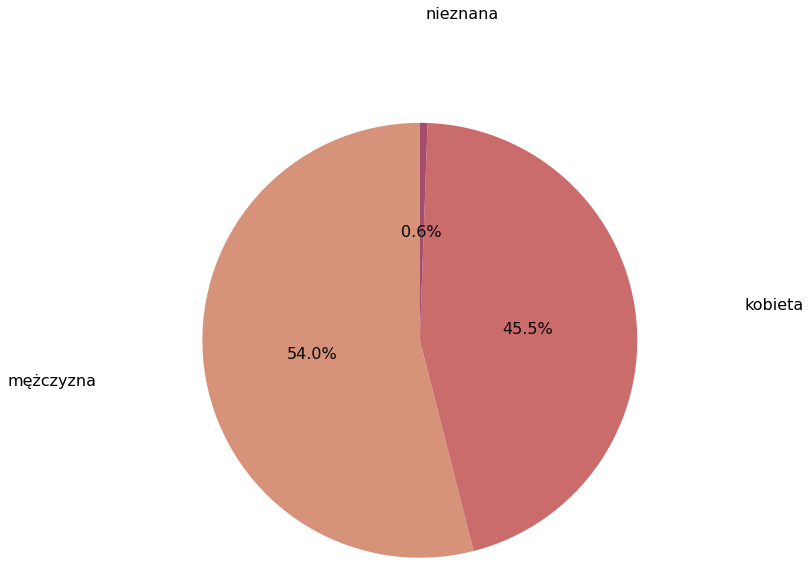

In [ ]:
colors = ["#d79379", "#cb6c6c","#a44c6c"]

plt.figure(figsize=(10, 5))
plt.rcParams['font.size'] = '16'

plt.pie(x = meta_data['sex'].value_counts(), 
        labels = ['mężczyzna', 'kobieta', 'nieznana'],  
        autopct="%.1f%%", 
        colors = colors,
        pctdistance=0.5, 
        labeldistance=1.5,
        radius = 2,
        startangle = 90)
plt.show()

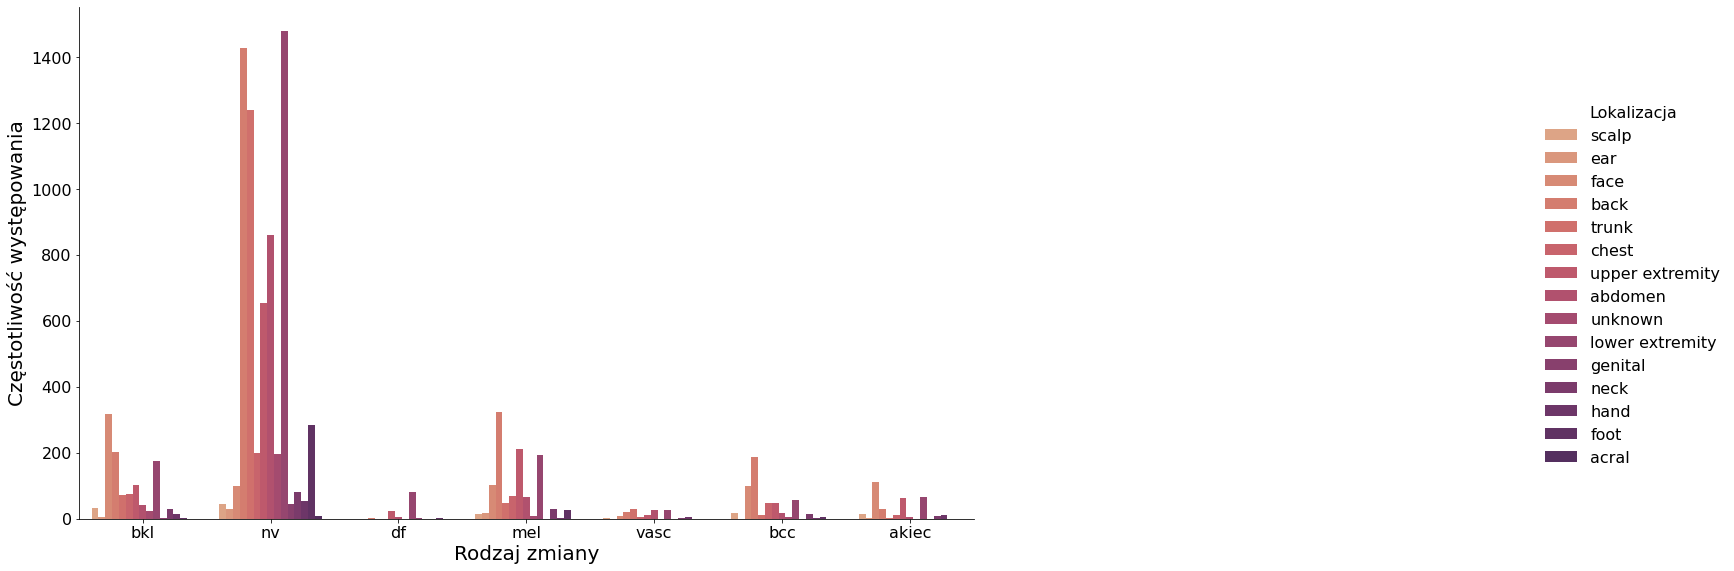

In [ ]:
plot = sns.catplot(x="dx", kind="count", hue="localization", palette='flare', data=meta_data)

plot.fig.set_size_inches(30, 9)
plot.set_xlabels('Rodzaj zmiany', size=20)
plot.set_ylabels('Częstotliwość występowania', size=20)
plot._legend.set_title('Lokalizacja')


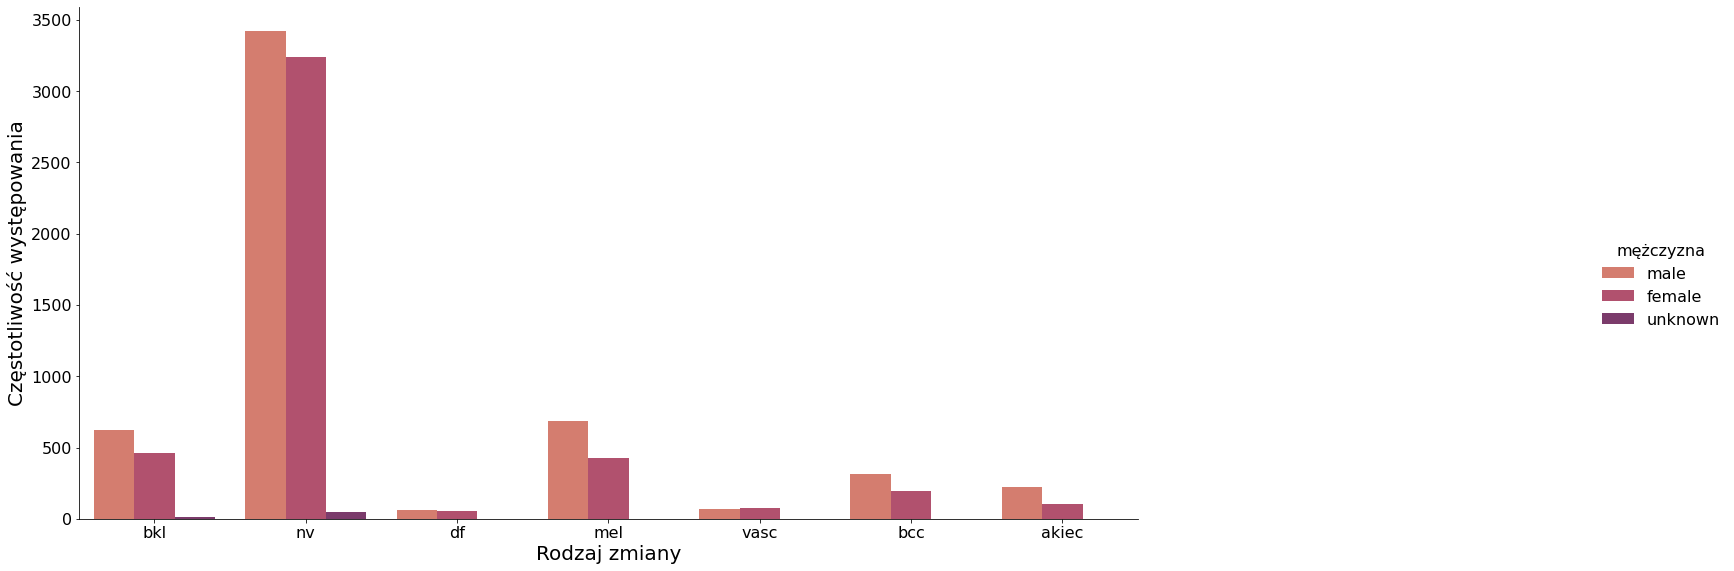

In [ ]:
plot = sns.catplot(x="dx", kind="count", hue="sex", palette='flare', data=meta_data)

plot.fig.set_size_inches(30, 9)
plot.set_xlabels('Rodzaj zmiany', size=20)
plot.set_ylabels('Częstotliwość występowania', size=20)
plot._legend.set_title('Płeć')

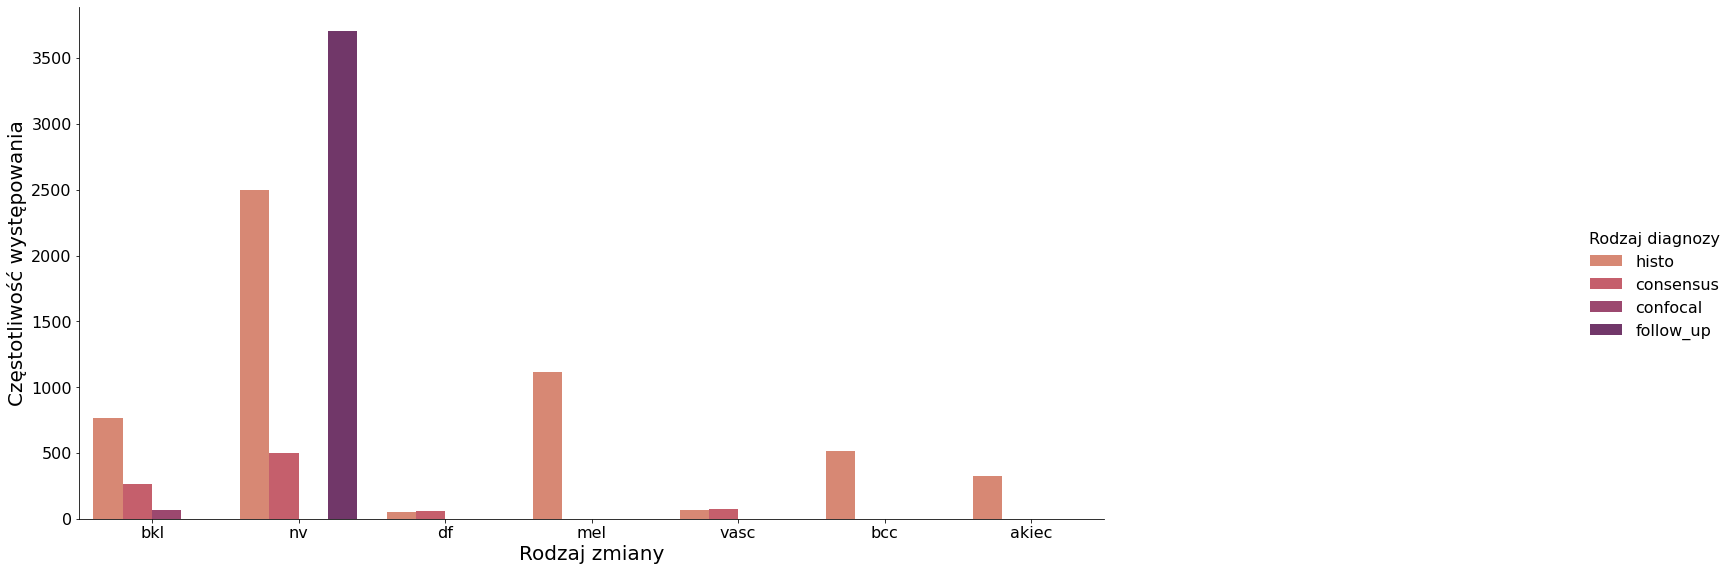

In [ ]:
plot = sns.catplot(x="dx", kind="count", hue="dx_type", palette='flare', data=meta_data)

plot.fig.set_size_inches(30, 9)
plot.set_xlabels('Rodzaj zmiany', size=20)
plot.set_ylabels('Częstotliwość występowania', size=20)
plot._legend.set_title('Rodzaj diagnozy')

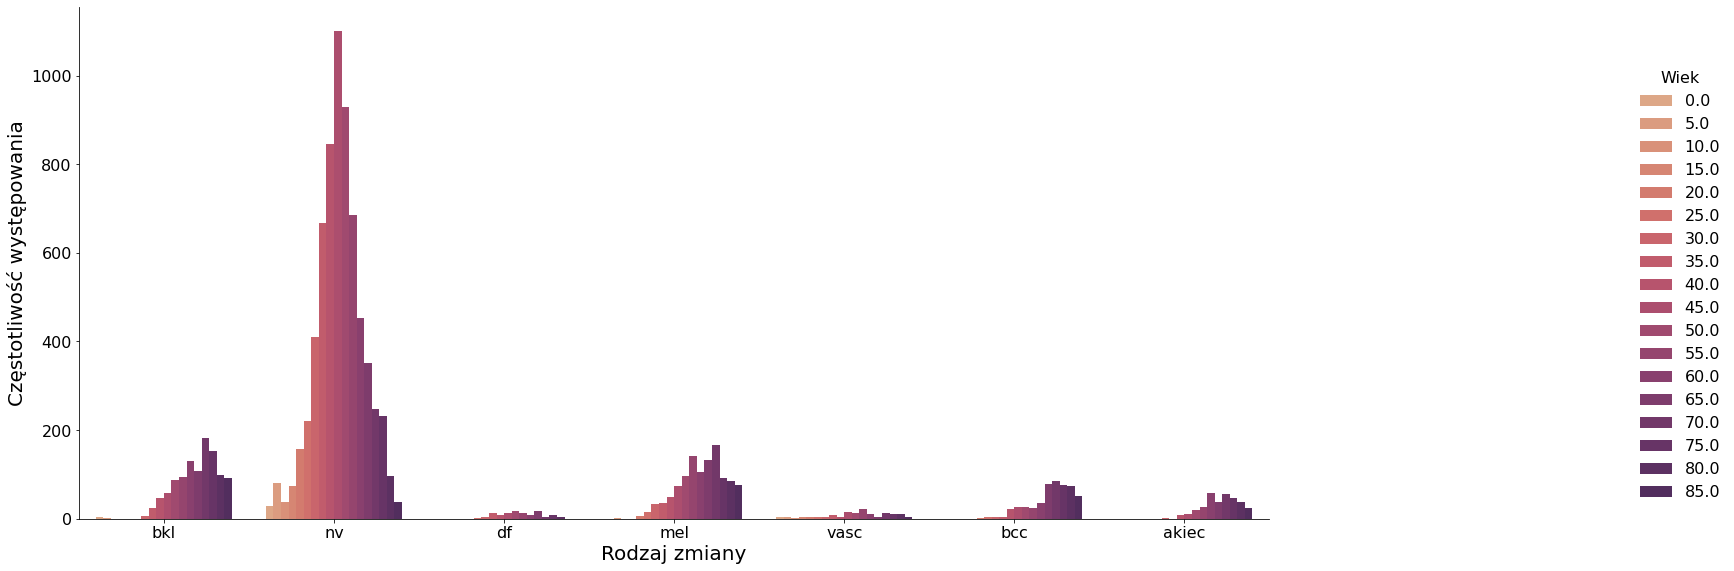

In [ ]:
plot = sns.catplot(x="dx", kind="count", hue="age", palette='flare', data=meta_data)

plot.fig.set_size_inches(30, 9)
plot.set_xlabels('Rodzaj zmiany', size=20)
plot.set_ylabels('Częstotliwość występowania', size=20)
plot._legend.set_title('Wiek')

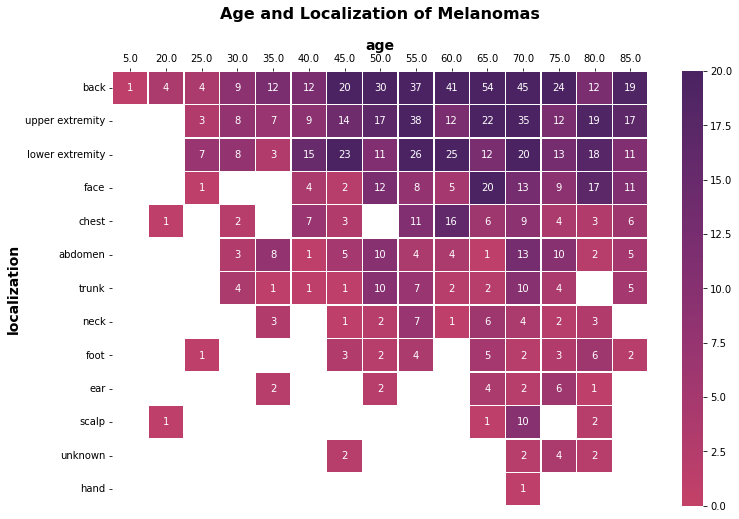

In [ ]:
skin_mel = meta_data.loc[:,['age','sex','localization','dx']]
skin_mel = skin_mel[skin_mel['dx'] == 'mel']

skin_local = skin_mel.groupby(['localization']).size().sort_values(ascending=False, inplace=False).reset_index()
skin_local.columns = ['localization', 'count']
sort_by = skin_local['localization']

skin_heat = skin_mel.groupby(['age','localization']).size().reset_index()
skin_heat.columns = ['age', 'localization', 'count']
skin_heat.sort_values('count', ascending=False, inplace=True)

def heatmap(df, index,columns,values,vmax,sort_by,Title):
    df_wide = df.pivot(index=index, columns=columns, values=values)
    df_wide = df_wide.reindex(index=sort_by)
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(df_wide, annot=True, fmt='.0f', yticklabels='auto', cmap=sns.color_palette("flare", as_cmap=True), center=.2,vmin = 0, vmax = vmax,linewidths=.5)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(columns,fontsize = 14,weight = 'bold')
    ax.set_ylabel(index,fontsize = 14,weight = 'bold')    
    ax.set_title(Title,fontsize = 16,weight = 'bold',pad=20)
    plt.show()
    
heatmap(skin_heat,'localization', 'age','count', 20,sort_by,'Age and Localization of Melanomas')

WIZUALIZACJA ZDJĘĆ

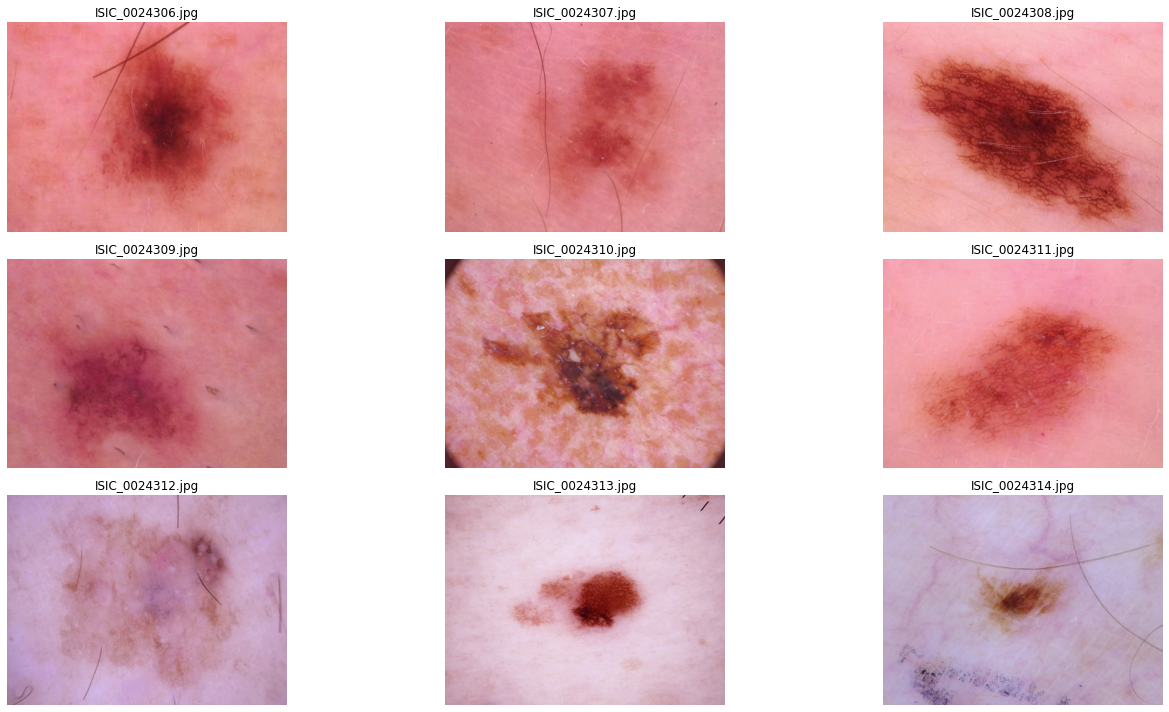

In [ ]:
image_path = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_part_1'
image = os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_part_1')

image.sort()

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(image_path, image[i]))
    plt.title(image[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

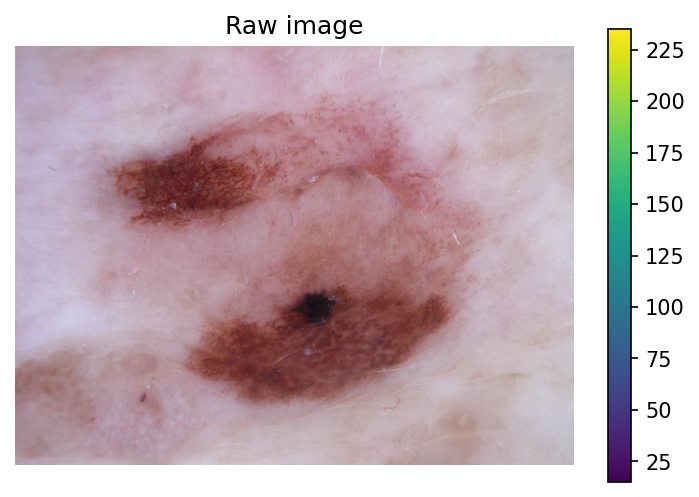

Rozmiar zdjęcia: (450, 600, 3)
Max pixel: 235.00
Min pixel 15.00
Średnia: 162.60 
Odchylenie standardowe: 40.41


In [ ]:
example_path = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_all'
example_img = os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_all')

sample_img = plt.imread(os.path.join(example_path, example_img[12]))

plt.figure(dpi=150)
plt.imshow(sample_img)
plt.colorbar()
plt.title('Raw image')
plt.axis("off")
plt.show()

print(f"Rozmiar zdjęcia: {sample_img.shape}")
print(f"Max pixel: {sample_img.max():.2f}")
print(f"Min pixel {sample_img.min():.2f}")
print(f"Średnia: {sample_img.mean():.2f} ")
print(f"Odchylenie standardowe: {sample_img.std():.2f}")

PRZENIESIENIE ZDJĘĆ DO FOLDERÓW KLAS

In [ ]:
# Reorganize data into subfolders based on their labels
#then use keras flow_from_dir or pytorch ImageFolder to read images with 
#folder names as labels

#Sort images to subfolders first 
import shutil

# Dump all images into a folder and specify the path:
data_dir = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_all/'

# Path to destination directory where we want subfolders
dest_dir = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_reorganized/'

# Read the csv file containing image names and corresponding labels
skin_df = pd.read_csv('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_metadata.csv')
print(skin_df['dx'].value_counts())

label=skin_df['dx'].unique().tolist()  #Extract labels into a list
label_images = []
'''
# Copy images to new folders
for i in label:
    os.mkdir(dest_dir + str(i) + "/")
    sample = skin_df[skin_df['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+ id +".jpg"))
    label_images=[]
'''

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


'\n# Copy images to new folders\nfor i in label:\n    os.mkdir(dest_dir + str(i) + "/")\n    sample = skin_df[skin_df[\'dx\'] == i][\'image_id\']\n    label_images.extend(sample)\n    for id in label_images:\n        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+ id +".jpg"))\n    label_images=[]\n'

In [ ]:
df_original = pd.read_csv('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_metadata.csv')

dupes = df_original.duplicated(subset = ['lesion_id'])

df_original['Duplicated'] = dupes

,lesion_id,image_id,dx,dx_type,age,sex,localization,Duplicated
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,False
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,True
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,False
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,True
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,False


In [ ]:
dupes.head()

0    False
1     True
2    False
3     True
4    False
dtype: bool

In [ ]:
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Duplicated
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,False
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,True
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,False
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,True
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,False


In [ ]:
print(df_original['Duplicated'].value_counts())

False    7470
True     2545
Name: Duplicated, dtype: int64


In [ ]:
print(df_original['duplicates'].value_counts())

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64


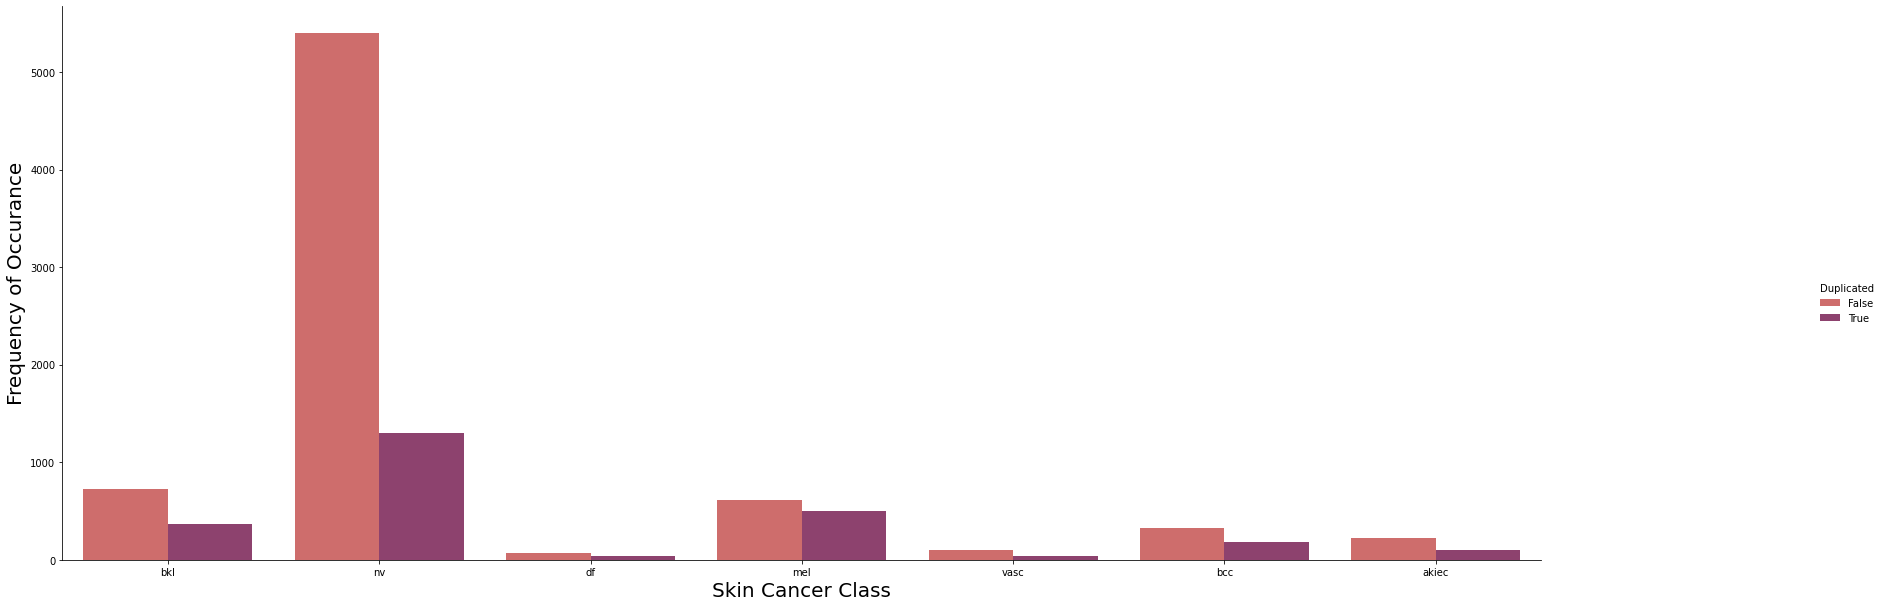

In [ ]:
plot = sns.catplot(x ="dx", kind="count", hue="Duplicated", palette='flare', data=df_original)

plot.fig.set_size_inches(30, 9)
plot.set_xlabels('Skin Cancer Class', fontsize=20)
plot.set_ylabels('Frequency of Occurance', fontsize=20)
plot._legend.set_title('Duplicated')

# CZY JA MOGE WYZBYC SIE POWTARZAJACYCH SIE ZDJEC Z NV ZEBY BARDZIEJ WYROWNAC ZBIORY????

## PODZIAŁ DANYCH: train 80%, test 10%, val 10%

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.

path_1 = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_reorganized/' 

path_2 = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_split/' 

splitfolders.ratio(path_1 , output=path_2, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=True) # default values

In [ ]:
path_1 = len(os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_split/train/nv'))
path_2 = len(os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_split/test/nv'))
path_3 = len(os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_split/val/nv'))

print("Train:", path_1 ,"+", "Test:", path_2,"+", "Val:", path_3, "=", path_1 + path_2 + path_3)

Train: 5364 + Test: 671 + Val: 670 = 6705


RÓWNOWAŻENIE

In [ ]:
# Distribution of data into various classes 
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
meta_data = pd.read_csv('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_metadata.csv')

print(meta_data.head())

# Numeric labels for cancer types 
label_encoder = LabelEncoder()
meta_data['label'] = label_encoder.fit_transform(meta_data["dx"]) 
print(list(label_encoder.classes_))

print(meta_data.head())
print(meta_data['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = meta_data[meta_data['label'] == 0]
df_1 = meta_data[meta_data['label'] == 1]
df_2 = meta_data[meta_data['label'] == 2]
df_3 = meta_data[meta_data['label'] == 3]
df_4 = meta_data[meta_data['label'] == 4]
df_5 = meta_data[meta_data['label'] == 5]
df_6 = meta_data[meta_data['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
     lesion_id      image_id   dx dx_type   age   sex localization  label
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp      2
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp      2
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp      2
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp      2
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear      2
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
0    50

Utworzenie zbioru binarnego, podzial na lagodne i zloscliwe (nv, mel+bcc)

In [ ]:
from distutils.dir_util import copy_tree

# copy subdirectory example
from_directory = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_split/val/bcc'
to_directory = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_frag/val/malignant'

copy_tree(from_directory, to_directory)

In [ ]:
path_1 = len(os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_frag/val/malignant'))
print(path_1)

162


CHECK SIZES

In [ ]:
path_1 = len(os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_split/val/nv'))
path_2 = len(os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_split/val/mel'))
path_3 = len(os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_split/val/bcc'))

path_4 = len(os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_frag/val/benign'))
path_5 = len(os.listdir('/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_frag/val/malignant'))

print(path_1, '=', path_4, path_2 + path_3, '=', path_5)

670 = 670 162 = 162


IMAGE DATA GENERATOR

In [12]:
img_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    shear_range = 10) 

In [35]:
data_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1./255)

In [13]:
train_path = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_frag/train/'
test_path = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_frag/test/'
val_path = '/content/drive/My Drive/INZYNIERKA/Dane_1/HAM10000_images_frag/val/'

#Liczba zdjęć w folderze train
print(f"Train set: {len(glob(os.path.join(train_path, '*', '*.jpg')))} = 80%")

#Liczba zdjęć w folderze test
print(f"Test set: {len(glob(os.path.join(test_path, '*', '*.jpg')))} = 10%")

#Liczba zdjęć w folderze val
print(f"Val set: {len(glob(os.path.join(val_path, '*', '*.jpg')))} = 10%")


Train set: 6665 = 80%
Test set: 835 = 10%
Val set: 832 = 10%


In [44]:
train = data_gen.flow_from_directory(
    train_path, 
    batch_size=20, 
    shuffle=True, 
    class_mode='binary', 
    target_size=(224, 224))

validation = data_gen.flow_from_directory(
    val_path, 
    batch_size=1, 
    shuffle=False, 
    class_mode='binary', 
    target_size=(224, 224))

test = test_gen.flow_from_directory(
    test_path, 
    batch_size=1, 
    shuffle=False, 
    class_mode='binary', 
    target_size=(224, 224))

Found 6665 images belonging to 2 classes.
Found 832 images belonging to 2 classes.
Found 835 images belonging to 2 classes.


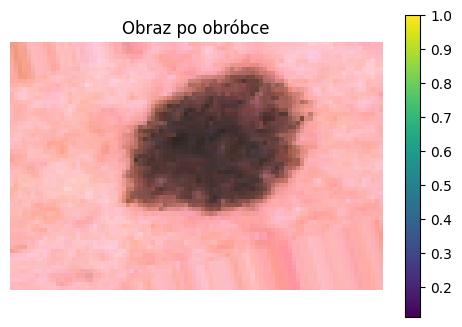

Rozmiar zdjęcia: (16, 60, 90, 3)
Max pixel: 255.00
Min pixel 0.00
Średnia: 161.49 
Odchylenie standardowe: 41.87


In [ ]:
trans_img, label = train.__getitem__(1)

plt.figure(dpi=100)
plt.imshow(trans_img[1]/255)
plt.colorbar()
plt.axis("off")
plt.title('Obraz po obróbce')
plt.show()

print(f"Rozmiar zdjęcia: {trans_img.shape}")
print(f"Max pixel: {trans_img.max():.2f}")
print(f"Min pixel {trans_img.min():.2f}")
print(f"Średnia: {trans_img.mean():.2f} ")
print(f"Odchylenie standardowe: {trans_img.std():.2f}")

WAGI KLAS

In [15]:
class_weights = sklearn.utils.class_weight.compute_class_weight(
           'balanced',
            classes = np.unique(train.classes), 
            y = train.classes)

class_weights = dict(zip(np.unique(train.classes), class_weights))

print(class_weights)

{0: 0.6212714392244594, 1: 2.5614911606456574}


## MODEL



---



In [16]:
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='AUC')]

optimizer = adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#Callbacks
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=0, factor=0.5, min_lr=0.00001)

#early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
our_model = Sequential()

our_model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(MaxPool2D(pool_size=(2, 2)))

our_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(MaxPool2D(pool_size=(2, 2)))

our_model.add(Flatten())
our_model.add(Dense(32, activation='relu'))
our_model.add(Dropout(0.3))

our_model.add(Dense(1, activation='softmax'))

our_model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  #optimizer=optimizer,  
                  metrics=METRICS)

In [ ]:
our_model.summary()

In [ ]:
r = our_model.fit(
    train, 
    epochs = 10,
    validation_data = validation, 
    class_weight = class_weights,
    steps_per_epoch = 100,
    validation_steps = 25
    )

Epoch 1/10
100/100 [==============================] - 45s 418ms/step - loss: 0.6667 - accuracy: 0.1975 - precision: 0.1971 - recall: 1.0000 - AUC: 0.5000 - val_loss: 0.1020 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 40s 401ms/step - loss: 0.6058 - accuracy: 0.1881 - precision: 0.1881 - recall: 1.0000 - AUC: 0.5000 - val_loss: 0.1693 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 42s 420ms/step - loss: 0.5992 - accuracy: 0.2040 - precision: 0.2040 - recall: 1.0000 - AUC: 0.5000 - val_loss: 0.2414 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 40s 402ms/step - loss: 0.5716 - accuracy: 0.1944 - precision: 0.1944 - recall: 1.0000 - AUC: 0.5000 - val_loss: 0.7741 - 

In [ ]:
our_evaluation = our_model.evaluate(test)

print(f"Test Accuracy: {our_evaluation[1]:.2f}")
print(f"Test Precision: {our_evaluation[2]:.2f}")
print(f"Test Recall: {our_evaluation[3]:.2f}")
print(f"Test AUC: {our_evaluation[4]:.2f}")

835/835 [==============================] - 21s 25ms/step - loss: 0.7162 - accuracy: 0.1964 - precision: 0.1964 - recall: 1.0000 - AUC: 0.5000
Test Accuracy: 0.20
Test Precision: 0.20
Test Recall: 1.00
Test AUC: 0.50




---



---



In [17]:
resnet50_base_model = ResNet50(input_shape=(60, 90, 3), pooling = 'avg', include_top=False, weights='imagenet')

resnet_model = tf.keras.Sequential([
        resnet50_base_model,
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(1,activation="softmax")])

adam_001 = tf.keras.optimizers.Adam(learning_rate=0.001)

resnet_model.compile(loss='binary_crossentropy', 
                  optimizer = optimizer,  
                  metrics = METRICS)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
class_weights

{0: 0.6212714392244594, 1: 2.5614911606456574}

In [19]:
resnet_r = resnet_model.fit(
    train,
    epochs = 10,
    validation_data = validation,
    class_weight = class_weights,
    steps_per_epoch = 100,
    #validation_steps = 25,
    #callbacks = [learning_rate_reduction, early_stopping_monitor]
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
 14/100 [===>..........................] - ETA: 11:00 - loss: 0.4583 - accuracy: 0.1821 - precision: 0.1821 - recall: 1.0000 - AUC: 0.5000

KeyboardInterrupt: ignored

In [ ]:
resnet_evaluation = resnet_model.evaluate(test)
 
print(f"Test Accuracy: {resnet_evaluation[1]:.2f}")
print(f"Test Precision: {resnet_evaluation[2]:.2f}")
print(f"Test Recall: {resnet_evaluation[3]:.2f}")
print(f"Test AUC: {resnet_evaluation[4]:.2f}")

835/835 [==============================] - 216s 259ms/step - loss: 1.1012 - accuracy: 0.1964 - precision: 0.1964 - recall: 1.0000 - AUC: 0.5000
Test Accuracy: 0.20
Test Precision: 0.20
Test Recall: 1.00
Test AUC: 0.50


835/835 [==============================] - 15s 17ms/step


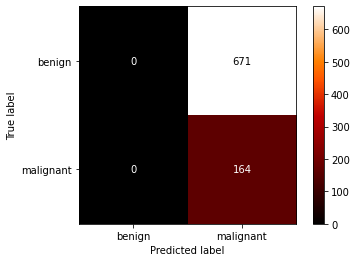

In [ ]:
resnet_pred = resnet_model.predict(test)

matrix = confusion_matrix(test.classes, (resnet_pred > 0.7).ravel())
 
ConfusionMatrixDisplay(matrix, display_labels = ["benign", "malignant"]).plot(cmap = plt.cm.gist_heat)
plt.show()



---



---





MODEL JAKIŚ

In [40]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',
input_shape=(224, 224, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 128)     

In [45]:
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("model compiled")

model compiled


In [47]:
history = model.fit(
    train,
    epochs=100,
    class_weight = class_weights,
    steps_per_epoch = 100,
    validation_data = validation,
    validation_steps = 40
    )

Epoch 1/100
100/100 [==============================] - 63s 627ms/step - loss: 0.6848 - accuracy: 0.6423 - val_loss: 0.6608 - val_accuracy: 0.6130
Epoch 2/100
100/100 [==============================] - 65s 648ms/step - loss: 0.6107 - accuracy: 0.6325 - val_loss: 0.6090 - val_accuracy: 0.6202
Epoch 3/100
100/100 [==============================] - 62s 622ms/step - loss: 0.5881 - accuracy: 0.6085 - val_loss: 0.5827 - val_accuracy: 0.6190
Epoch 4/100
100/100 [==============================] - 62s 618ms/step - loss: 0.5947 - accuracy: 0.6260 - val_loss: 0.6646 - val_accuracy: 0.5938
Epoch 5/100
100/100 [==============================] - 61s 611ms/step - loss: 0.5814 - accuracy: 0.6232 - val_loss: 0.5717 - val_accuracy: 0.6154
Epoch 6/100
100/100 [==============================] - 62s 623ms/step - loss: 0.5760 - accuracy: 0.6121 - val_loss: 0.5675 - val_accuracy: 0.6250
Epoch 7/100
100/100 [==============================] - 62s 624ms/step - loss: 0.5396 - accuracy: 0.6410 - val_loss: 0.6917 -

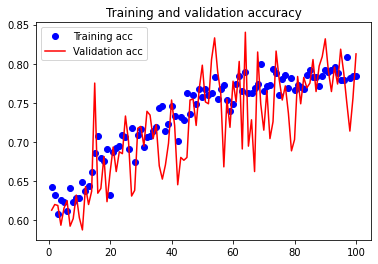

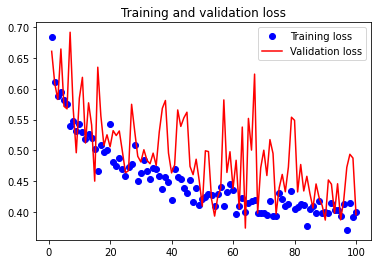

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [55]:
model_evaluation = model.evaluate(test)
 
print(f"Test Accuracy: {model_evaluation[1]:.2f}")


835/835 [==============================] - 389s 467ms/step - loss: 0.3993 - accuracy: 0.7928
Test Accuracy: 0.79


835/835 [==============================] - 12s 15ms/step


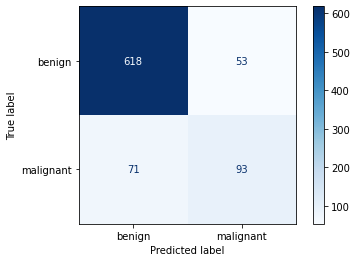

In [63]:
model_pred = model.predict(test)

matrix = confusion_matrix(test.classes, (model_pred > 0.7).ravel())
 
ConfusionMatrixDisplay(matrix, display_labels = ["benign", "malignant"]).plot(cmap = 'Blues')
plt.show()

In [64]:
model.save('/content/drive/My Drive/INZYNIERKA/Model_1_CNN.h5')